In [ ]:
# from selenium.webdriver.support.ui import Select
# from selenium.webdriver.support.wait import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.webdriver.common.keys import Keys

# from selenium.common.exceptions import ElementClickInterceptedException 
# from selenium.common.exceptions import TimeoutException 
# from selenium.common.exceptions import ElementNotInteractableException
# from selenium.webdriver.common.action_chains import ActionChains
# import time
# from selenium.webdriver.chrome.service import Service

# Rune once: Libraries and Sentiment Analysis algorithm

In [2]:
import pandas as pd
import numpy as np
import copy
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
directory_of_chromedriver="C:/Users/argyropoulos_c/Documents/chromedriver.exe"

In [3]:
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [4]:
#Create API and SERVICE credential on Google Cloud project, download and rename json
# https://docs.gspread.org/en/latest/oauth2.html use the step "for bots"
# run a shell to create a directory: mkdir %APPDATA%\gspread
# move credentials.json %APPDATA%\gspread\service_account.json
sa = gspread.service_account()
sh = sa.open("data-gspread")
#Set up the worksheet artifacts
wks1 = sh.worksheet('sheet1')
wks2 = sh.worksheet('sheet2')
wks3 = sh.worksheet('sheet3')
wks3.format('E', {'numberFormat': {'type' : 'NUMBER', 'pattern': '0.0#'}})
#to format the number with commas instead of dots, avoids headaches for later
# wks1.format('E', {'numberFormat': {'type' : 'NUMBER', 'pattern': '0,0#'}})
#if there are value on the worksheet, pull it
# headers = data.pop(0)

{'spreadsheetId': '1d7OJAxV-wvLh1fQKjYW7XPlc-el3v1TAhteFYmdJ4Hc',
 'replies': [{}]}

In [5]:
#Sentiment analysis task
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
# with pd.option_context('display.max_colwidth', None):
#   display(df.loc[1,:])

c:\Users\argyropoulos_c\Anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


# Sentiment analysis Tasks.
Here is the part where you modify the cells. Modify the range of pages in the first for loop, the keyword to signal comment extraction (if necessary), and the target language for translation (if necessary) 

In [276]:
#Pull all comments from review pages
#Change : range with right number of pages, name of div element
#Extraction product review Ozon done : 555243165, 229186105, 765498246, 154639862, 765278208, 209995033, 208934941
res = []

for i in range(1,18):
    attempt_counter = 0
    result = False
    while attempt_counter < 5 and not result:
        try:
            driver = webdriver.Chrome(executable_path=directory_of_chromedriver)
            driver.get(f'https://www.ozon.ru/product/208934941/reviews?page={i}')
            res.append(driver.find_element(By.XPATH, '//div[@class="u3x"]').text.splitlines())
            driver.close()
            result = True
        except NoSuchElementException:
            print(f'Page {i}: Error N{attempt_counter+1}')
            attempt_counter += 1
            driver.close()
            
    if attempt_counter == 5:
        print(f'Error on page {i}')

C:\Users\argyropoulos_c\AppData\Local\Temp\ipykernel_14140\2756605080.py:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=directory_of_chromedriver)


In [289]:
#Store the comments
comments = []
df = pd.DataFrame()

for sublist in res:
    for i in range(len(sublist)):
        if sublist[i] == "Комментарий":
            comments.append(sublist[i+1])

data = pd.DataFrame(comments, columns=['comment'])

In [291]:
#Translate comments
from yandexfreetranslate import YandexFreeTranslate
yt = YandexFreeTranslate(api = "ios")
data["translation"] = data["comment"].apply(lambda x: yt.translate('ru','en',
                x) if type(x) == str else x)

In [292]:
#Check for losses
data['translation'] = data['translation'].astype(str).str.lower()
print(len(data))
data.dropna(subset=['translation'])
print(len(data))

356
356


In [294]:
#Upload final results in Google sheet
wks1.clear()
set_with_dataframe(
    worksheet=wks1, dataframe=data, include_index=False,
    include_column_header=False, resize=True)

In [6]:
#Merge new results with previous ones
gspread_data2 = wks2.get_all_values()
df = pd.DataFrame (gspread_data2, columns = ['comment', 'translation'])
df_final = pd.concat([df,data])

NameError: name 'data' is not defined

In [296]:
#Push merged results
wks2.clear()
set_with_dataframe(
    worksheet=wks2, dataframe=df_final, include_index=False,
    include_column_header=False, resize=True)

In [8]:
#Get list for the model
X= df_final['translation'].values.tolist()
df_final["sentiment"] = [classifier(x) for x in X]
Y = df_final['sentiment'].values.tolist()

In [21]:
#Push merged results
wks2.clear()
set_with_dataframe(
    worksheet=wks2, dataframe=df_final, include_index=False,
    include_column_header=False, resize=True)

In [9]:
#Merge each sentiment together
merged_dict = {}
for lst in Y:
    for list in lst:
        for dictionary in list:
            key = dictionary['label']
            value = dictionary['score']
            if key in merged_dict:
                merged_dict[key].append(value)
            else:
                merged_dict[key] = [value]

In [10]:
sentiment = pd.DataFrame.from_dict(merged_dict, orient='columns')

In [11]:
sentiment.describe()

,anger,disgust,fear,joy,neutral,sadness,surprise
count,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000
mean,0.065629,0.080111,0.108082,0.453128,0.226780,0.035483,0.030788
std,0.107134,0.161112,0.186830,0.394391,0.262045,0.087052,0.103060
min,0.000559,0.000293,0.000250,0.000366,0.000217,0.000786,0.000268
25%,0.008782,0.004434,0.004941,0.032332,0.016929,0.004587,0.003233
50%,0.024885,0.019746,0.020465,0.420463,0.105528,0.011374,0.006826
75%,0.079761,0.068164,0.110582,0.872255,0.368839,0.030396,0.016550
max,0.952701,0.988976,0.991257,0.993760,0.951080,0.976460,0.985916


In [301]:
#Push sentiment table
wks3.clear()
set_with_dataframe(
    worksheet=wks3, dataframe=sentiment, include_index=False,
    include_column_header=True, resize=True)

# Post-retrieval workspace
Once all the retrieval is done, there's no need to do it all over again. Just retrieve the stored data

In [7]:
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [8]:
# Import the word cloud function  
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [9]:
#Create API and SERVICE credential on Google Cloud project, download and rename json
# https://docs.gspread.org/en/latest/oauth2.html use the step "for bots"
# run a shell to create a directory: mkdir %APPDATA%\gspread
# move credentials.json %APPDATA%\gspread\service_account.json
sa = gspread.service_account()
sh = sa.open("data-gspread")
#Set up the worksheet artifacts
wks1 = sh.worksheet('sheet1')
wks2 = sh.worksheet('sheet2')
wks3 = sh.worksheet('sheet3')
wks3.format('E', {'numberFormat': {'type' : 'NUMBER', 'pattern': '0.0#'}})
#to format the number with commas instead of dots, avoids headaches for later
# wks1.format('E', {'numberFormat': {'type' : 'NUMBER', 'pattern': '0,0#'}})
#if there are value on the worksheet, pull it
# headers = data.pop(0)

{'spreadsheetId': '1d7OJAxV-wvLh1fQKjYW7XPlc-el3v1TAhteFYmdJ4Hc',
 'replies': [{}]}

In [10]:
#Statistics on sentiment
gspread_data3 = wks3.get_all_values()
headers = gspread_data3.pop(0)
df_sentiment = pd.DataFrame(gspread_data3, columns=headers)
gspread_data2 = wks2.get_all_values()
df = pd.DataFrame(gspread_data2, columns=['comment','translation','sentiment'])
#put it back to float (TODO)
# df_sentiment_test = df_sentiment.astype(float)

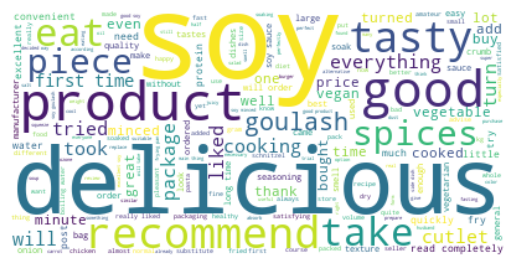

In [11]:
text = " ".join(review for review in df.translation)
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["meat",'cook','taste'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()